In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Preprocessing</h2> 

In [2]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000256


In [3]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [4]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [6]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [7]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [8]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


<h2>3.2 Spliting data into Train and Test(80:20) </h2>

In [9]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

In [10]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


In [11]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


## Creating sparse matrix from data frame 

In [12]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

It is present in your pwd, getting it from disk....
DONE..
0:00:04.711829
Sparsity Of Train matrix : 99.8292709259195 % 


In [13]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

It is present in your pwd, getting it from disk....
DONE..
0:00:01.467995
Sparsity Of Test matrix : 99.95731772988694 % 


## Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [14]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [15]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

In [16]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


In [17]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


## Computing Movie-Movie Similarity matrix 

In [18]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)
print(m_m_sim_sparse.shape)

It is there, We will get it.
Done ...
It's a  (17771, 17771)  dimensional matrix
0:00:48.809419
(17771, 17771)


In [19]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:29.914661


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

## Finding most similar movies using similarity matrix 

In [20]:
import os
os.getcwd()

#os.chdir('/home/sunney_sood/netflix/')

'/home/sunney_sood/netflix'

In [21]:
os.getcwd()

'/home/sunney_sood/netflix'

In [22]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 54.64 ms
Type conversion took: 10.11 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# 4.1 Sampling Data 

In [23]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

### Build sample train data from the train & test data

In [24]:
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=3000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.193343


In [25]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=10000, no_movies=1500,
                                                 path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.064426


## 4.2 Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [26]:
sample_train_averages = dict()


In [27]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5875813607223455}

In [28]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.923076923076923


In [29]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.752


In [30]:
print('No of ratings in Our Sampled train matrix is : {}'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 856986
No of ratings in Our Sampled test  matrix is : 55123


In [31]:
sample_test_averages = dict()
# get the global average of ratings in our test set.
global_average = sample_test_sparse_matrix.sum()/sample_test_sparse_matrix.count_nonzero()
sample_test_averages['global'] = global_average
sample_test_averages

sample_test_averages['user'] = get_average_ratings(sample_test_sparse_matrix, of_users=True)
#print('\nAverage rating of user 1515220 :',sample_test_averages['user'][1515220])

sample_test_averages['movie'] =  get_average_ratings(sample_test_sparse_matrix, of_users=False)
#print('\n AVerage rating of movie 15153 :',sample_test_averages['movie'][15153])

print('No of ratings in Our Sampled test matrix is : {}'.format(sample_test_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled test matrix is : 55123
No of ratings in Our Sampled test  matrix is : 55123


### Featurizing train data

In [32]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [33]:
def user_movie_pair(sample_train_users,sample_train_movies,sample_train_ratings,sample_train_sparse_matrix,file_name):
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open(file_name, mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
                #st = datetime.now()
            #     print(user, movie)    
                #--------------------- Ratings of "movie" by similar users of "user" ---------------------
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            #     print(top_sim_users_ratings, end=" ") 
                        #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            #     print(top_sim_movies_ratings, end=" : -- ")

                #-----------------prepare the row to be stores in a file-----------------#
                row = list()
                row.append(user)
                row.append(movie)
                # Now add the other features to this data...
                row.append(sample_train_averages['global']) # first feature
                # next 5 features are similar_users "movie" ratings
                row.extend(top_sim_users_ratings)
                # next 5 features are "user" ratings for similar_movies
                row.extend(top_sim_movies_ratings)
                # Avg_user rating
                row.append(sample_train_averages['user'][user])
                # Avg_movie rating
                row.append(sample_train_averages['movie'][movie])

                # finalley, The actual Rating of this user-movie pair...
                row.append(rating)
                count = count + 1

                #return row
                # add rows to the file opened..
                reg_data_file.write(','.join(map(str, row)))
                reg_data_file.write('\n')        
                if (count)%10000 == 0:
                    # print(','.join(map(str, row)))
                    print("Done for {} rows----- {}".format(count, datetime.now() - start))
    

In [34]:
#print(type(sample_train_users))
#print(len(sample_train_movies))
print(len(sample_train_ratings))

sample_train_ratings[:107123]

process_step = np.arange(len(sample_train_ratings)//8,len(sample_train_ratings),len(sample_train_ratings)//8)
process_step

#file_name = []
initial = "sample\reg_train"

856986


In [35]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
import os
from multiprocessing import Process, current_process

processes = []

start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    st = datetime.now()
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[:107123],sample_train_movies[:107123],
                              sample_train_ratings[:107123],sample_train_sparse_matrix,initial + "_1"))
    processes.append(process)
    process.start()
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[107123:214246],sample_train_movies[107123:214246],
                              sample_train_ratings[107123:214246],sample_train_sparse_matrix,initial + "_2") )
    processes.append(process)
    process.start()
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[214246:321369],sample_train_movies[214246:321369],
                              sample_train_ratings[214246:321369],sample_train_sparse_matrix,initial + "_3") )
    processes.append(process)
    process.start()
    
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[321369:428492],sample_train_movies[321369:428492],
                              sample_train_ratings[321369:428492],sample_train_sparse_matrix,initial + "_4") )
    processes.append(process)
    process.start()
    
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[428492:535615],sample_train_movies[428492:535615],
                              sample_train_ratings[428492:535615],sample_train_sparse_matrix,initial + "_5") )
    processes.append(process)
    process.start()
    
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[535615:642738],sample_train_movies[535615:642738],
                              sample_train_ratings[535615:642738],sample_train_sparse_matrix,initial + "_6") )
    processes.append(process)
    process.start()
    
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[642738:749861],sample_train_movies[642738:749861],
                              sample_train_ratings[642738:749861],sample_train_sparse_matrix,initial + "_7") )
    processes.append(process)
    process.start()
    
    process = Process(target = user_movie_pair, 
                      args = (sample_train_users[749861:],sample_train_movies[749861:],
                              sample_train_ratings[749861:],sample_train_sparse_matrix,initial + "_8") )
    processes.append(process)
    process.start()
    
    #user_movie_pair(sample_train_users,sample_train_movies,sample_train_ratings,sample_train_sparse_matrix)
    print(datetime.now() - start)

File already exists you don't have to prepare again...


In [36]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
#reg_train.columns = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.587581,5,5,3,4,4.0,3,5.0,4.0,3.0,2.0,3.882353,3.611111,5
1,233949,10,3.587581,4,4,5,1,3.0,2,3.0,2.0,3.0,3.0,2.692308,3.611111,3
2,555770,10,3.587581,4,5,4,4,5.0,4,2.0,5.0,4.0,4.0,3.795455,3.611111,4
3,767518,10,3.587581,2,5,4,4,3.0,5,5.0,4.0,4.0,3.0,3.884615,3.611111,5
4,894393,10,3.587581,3,5,4,4,3.0,4,4.0,4.0,4.0,4.0,4.000000,3.611111,4


### Featurizing test data 

In [37]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)
sample_test_averages['global']

3.630861890680841

In [38]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)

It is already created...


In [39]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5
1,898730,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3
2,941866,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4
3,1280761,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,1


### Transforming data for Surprise models

In [40]:
from surprise import Reader, Dataset

In [41]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [42]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (898730, 71, 3), (941866, 71, 4)]

<h2> 4.4 Applying Machine Learning models </h2>

In [43]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [44]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

In [45]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

## XGBoost with initial 13 features 

In [46]:
import xgboost as xgb

from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [47]:
y_train.values.reshape(-1,1).shape

(856986, 1)

In [48]:
y_train[1:5]

1    3
2    4
3    5
4    4
Name: rating, dtype: int64

In [49]:
import time
from sklearn.model_selection import GridSearchCV

start_time = time.time()

parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'n_estimators' : [3,5,7,9]
}

model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)  

# Summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

/home/sunney_sood/.local/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sunney_sood/.local/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -0.924586 using {'n_estimators': 9, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 1.0, 'num_boost_round': 100, 'eta': 0.05}
Execution time: 589.4488108158112 ms


### Conclusion:


In [50]:
depth_gbdt = grid.best_params_['max_depth']
eta_gbdt = grid.best_params_['eta']
num_boost_rount_gbdt = grid.best_params_['num_boost_round']
subsample_gbdt = grid.best_params_['subsample']
colsample_bytree_gbdt = grid.best_params_['colsample_bytree']
best_n_estimators = grid.best_params_['n_estimators']

In [51]:
# initialize Our first XGBoost model...
#first_xgb = xgb.XGBRegressor(silent=False, n_jobs=best_n_jobs, random_state=15, n_estimators=best_n_estimators)
first_xgb = xgb.XGBRegressor(silent=False, random_state=15, 
                             max_depth=depth_gbdt
                           ,num_boost_round = num_boost_rount_gbdt
                           ,eta = eta_gbdt
                           ,subsample = subsample_gbdt
                           ,colsample_bytree = colsample_bytree_gbdt
                             ,n_estimators=best_n_estimators)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

Training the model..
[18:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:16.687278

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.629753225231773
MAPE :  39.711677766442264


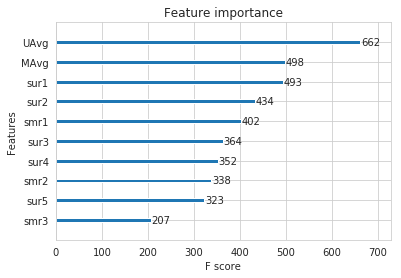

In [52]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(first_xgb, max_num_features=10) # top 10 most important features
#plt.show()

## Suprise BaselineModel 

In [53]:
x_train.shape

#https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#https://github.com/NicolasHug/Surprise/issues/318
#https://github.com/NicolasHug/Surprise/issues/190
#https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-tune-an-algorithm-parameters
#https://surprise.readthedocs.io/en/stable/getting_started.html#tuning-algorithm-parameters

(856986, 13)

In [54]:
from surprise.model_selection import GridSearchCV
from surprise import BaselineOnly 

parameters = { 'bsl_options': 
              {'method': ['sgd'],
                'reg' : [0.0001,0.001,0.01,0.1,1],
                'learning_rate': [0.0005, 0.005, 0.05,0.5],
                'n_epochs' : [5,10,15,20,35]
              }
            }

gs = GridSearchCV(BaselineOnly, parameters, measures=['rmse', 'mae'], cv=2,n_jobs=5)
gs.fit(train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.929479451452445
{'bsl_options': {'learning_rate': 0.005, 'reg': 0.01, 'n_epochs': 35, 'method': 'sgd'}}


In [55]:
gs.best_params['rmse']['bsl_options']['learning_rate']

0.005

In [56]:
lr = gs.best_params['rmse']['bsl_options']['learning_rate']
rg  = gs.best_params['rmse']['bsl_options']['reg']
n_epoch = gs.best_params['rmse']['bsl_options']['n_epochs']

In [57]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': lr,
               'reg' : rg,
               'n_epochs': n_epoch          
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:09.974028 

Evaluating the model with train data..
time taken : 0:00:07.387008
---------------
Train Data
---------------
RMSE : 0.899696058034443

MAPE : 27.422880460407008

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.515649
---------------
Test Data
---------------
RMSE : 1.0882648990208073

MAPE : 35.15438114239405

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:17.877419


## XGBoost with initial 13 features + Surprise Baseline predictor

In [58]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5,3.587581
1,898730,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3,3.587581


In [59]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [60]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'n_estimators' : [3,5,7,9]
}

model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)  

# Summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

depth_gbdt = grid.best_params_['max_depth']
eta_gbdt = grid.best_params_['eta']
num_boost_rount_gbdt = grid.best_params_['num_boost_round']
subsample_gbdt = grid.best_params_['subsample']
colsample_bytree_gbdt = grid.best_params_['colsample_bytree']
best_n_estimators = grid.best_params_['n_estimators']

[19:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -0.924616 using {'n_estimators': 9, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 1.0, 'num_boost_round': 100, 'eta': 0.05}
Execution time: 662.8906471729279 ms


Training the model..
[19:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:18.392002

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.625556549717856
MAPE :  39.63130175233669


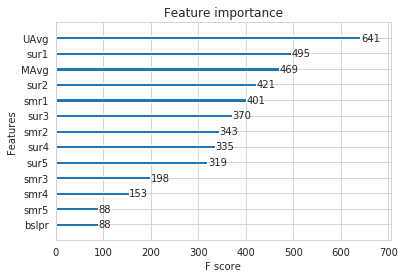

In [61]:
# initialize Our first XGBoost model...
#xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
xgb_bsl = xgb.XGBRegressor(silent=False, random_state=15, 
                             max_depth=depth_gbdt
                           ,num_boost_round = num_boost_rount_gbdt
                           ,eta = eta_gbdt
                           ,subsample = subsample_gbdt
                           ,colsample_bytree = colsample_bytree_gbdt
                             ,n_estimators=best_n_estimators)

train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

## Surprise KNNBaseline predictor 

In [62]:
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV

parameters = { 'bsl_options': 
              {'method': ['sgd'],
                'user_based' : [True],
                'name': ['pearson_baseline'],
                'min_support': [2,4,6,8],
                'shrinkage' : [5,15,25,35],
               'k' : [25,50,75,100]
               
              }
            }

gs = GridSearchCV(KNNBaseline, parameters, measures=['rmse', 'mae'], cv=2,n_jobs = 5)
gs.fit(train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9357276475560499
{'bsl_options': {'k': 25, 'name': 'pearson_baseline', 'user_based': True, 'min_support': 2, 'method': 'sgd', 'shrinkage': 5}}


In [63]:
support = gs.best_params['rmse']['bsl_options']['min_support']
shrink  = gs.best_params['rmse']['bsl_options']['shrinkage']
k_value = gs.best_params['rmse']['bsl_options']['k']

In [64]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': shrink,
               'min_support': support
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=k_value, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:07:15.894040 

Evaluating the model with train data..
time taken : 0:25:38.163478
---------------
Train Data
---------------
RMSE : 0.4156659936100566

MAPE : 11.65095489448479

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.042372
---------------
Test Data
---------------
RMSE : 1.087852478142926

MAPE : 35.14230871672305

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:32:55.100751


## Surprise KNNBaseline with movie movie similarities

In [65]:
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV

parameters = { 'bsl_options': 
              {'method': ['sgd'],
                'user_based' : [True],
                'name': ['pearson_baseline'],
                'min_support': [2,4,6,8],
                'shrinkage' : [5,15,25,35],
                'k' : [25,50,75,100]
               
              }
            }

gs = GridSearchCV(KNNBaseline, parameters, measures=['rmse', 'mae'], cv=2,n_jobs = 4)
gs.fit(train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9357836558969945
{'bsl_options': {'k': 25, 'name': 'pearson_baseline', 'user_based': True, 'min_support': 2, 'method': 'sgd', 'shrinkage': 5}}


In [66]:
support = gs.best_params['rmse']['bsl_options']['min_support']
shrink  = gs.best_params['rmse']['bsl_options']['shrinkage']
k_value = gs.best_params['rmse']['bsl_options']['k']

In [67]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': shrink,
               'min_support': support
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=k_value, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:13.481329 

Evaluating the model with train data..
time taken : 0:02:17.557326
---------------
Train Data
---------------
RMSE : 0.5184972304532561

MAPE : 14.80923218141059

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.535073
---------------
Test Data
---------------
RMSE : 1.0881187106120334

MAPE : 35.1472168668651

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:31.575405


## XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

In [68]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5,3.587581,3.587581,3.587581
1,898730,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3,3.587581,3.587581,3.587581


In [69]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [70]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'n_estimators' : [3,5,7,9]
}

model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)  

# Summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

depth_gbdt = grid.best_params_['max_depth']
eta_gbdt = grid.best_params_['eta']
num_boost_rount_gbdt = grid.best_params_['num_boost_round']
subsample_gbdt = grid.best_params_['subsample']
colsample_bytree_gbdt = grid.best_params_['colsample_bytree']
best_n_estimators = grid.best_params_['n_estimators']

[04:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -0.924540 using {'n_estimators': 9, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 1.0, 'num_boost_round': 100, 'eta': 0.05}
Execution time: 900.0494055747986 ms


Training the model..
[04:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:22.473797

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.6407511491605584
MAPE :  39.88660736337124


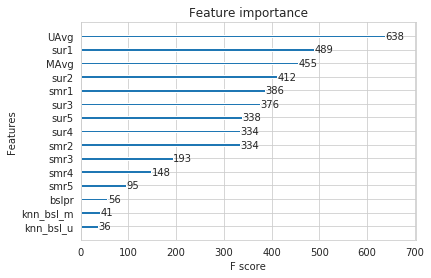

In [71]:
# declare the model
#xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
xgb_knn_bsl = xgb.XGBRegressor(silent=False, random_state=15, 
                             max_depth=depth_gbdt
                           ,num_boost_round = num_boost_rount_gbdt
                           ,eta = eta_gbdt
                           ,subsample = subsample_gbdt
                           ,colsample_bytree = colsample_bytree_gbdt
                             ,n_estimators=best_n_estimators)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

### Matrix Factorization Techniques

#### SVD Matrix Factorization User Movie intractions 

In [72]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

parameters = {  
                'n_factors' : [15,30,60,85],
                'biased' : [True],
                'lr_all' : [0.0001,0.001,0.01,0.1],
                'reg_all': [0.0005, 0.005, 0.05,0.5],
                'n_epochs' : [5,15,25,35]
              }
    

#trainset = train_data.build_full_trainset()


#bsl = BaselineOnly()
gs = GridSearchCV(SVD, parameters, measures=['rmse', 'mae'], cv=2,n_jobs = 5)
gs.fit(train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

lr = gs.best_params['rmse']['lr_all']
rg  = gs.best_params['rmse']['reg_all']
n_factor = gs.best_params['rmse']['n_factors']
n_epoch = gs.best_params['rmse']['n_epochs']

0.9189596486955769
{'n_factors': 30, 'reg_all': 0.05, 'n_epochs': 15, 'lr_all': 0.01, 'biased': True}


In [73]:
# initiallize the model
svd = SVD(n_factors=n_factor, 
          lr_all = lr,
          reg_all = rg,
          n_epochs = n_epoch,
          biased=True, random_state=15, verbose=True)

svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Done. time taken : 0:00:20.002312 

Evaluating the model with train data..
time taken : 0:00:10.196507
---------------
Train Data
---------------
RMSE : 0.8175957631146862

MAPE : 24.81752018358384

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.482093
---------------
Test Data
---------------
RMSE : 1.0877628436804372

MAPE : 35.11260257637676

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:30.682338


#### SVD Matrix Factorization with implicit feedback from user ( user rated movies ) 

In [74]:
from surprise.model_selection import GridSearchCV
from surprise import SVDpp

parameters = {  
                'n_factors' : [15,45,60,85],
                #'biased' : [True],
                'lr_all' : [0.0001,0.001,0.01,0.1],
                'reg_all': [0.0005, 0.005, 0.05,0.5],
                'n_epochs' : [5,15,25,35]
              }

#trainset = train_data.build_full_trainset()
#bsl = BaselineOnly()
gs = GridSearchCV(SVDpp, parameters, measures=['rmse', 'mae'], cv=2,n_jobs = 5)
gs.fit(train_data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

lr = gs.best_params['rmse']['lr_all']
rg  = gs.best_params['rmse']['reg_all']
n_factor = gs.best_params['rmse']['n_factors']
n_epoch = gs.best_params['rmse']['n_epochs']

0.9069647801185459
{'n_factors': 15, 'n_epochs': 35, 'lr_all': 0.001, 'reg_all': 0.0005}


In [76]:
# initiallize the model
svdpp = SVDpp(n_factors=n_factor, 
          lr_all = lr,
          reg_all = rg,
          n_epochs = n_epoch,
          #biased=True,
              random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 20
 processing epoch 21
 processing epoch 22
 processing epoch 23
 processing epoch 24
 processing epoch 25
 processing epoch 26
 processing epoch 27
 processing epoch 28
 processing epoch 29
 processing epoch 30
 processing epoch 31
 processing epoch 32
 processing epoch 33
 processing epoch 34
Done. time taken : 0:32:13.013175 

Evaluating the model with train data..
time taken : 0:01:33.635572
---------------
Train Data
---------------
RMSE : 0.8237947179648067

MAPE : 24.608738637652106

adding train results in the dictionary..

Evaluating 

### XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques 

In [77]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']


In [78]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'n_estimators' : [3,5,7,9]
}

model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)  

# Summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

depth_gbdt = grid.best_params_['max_depth']
eta_gbdt = grid.best_params_['eta']
num_boost_rount_gbdt = grid.best_params_['num_boost_round']
subsample_gbdt = grid.best_params_['subsample']
colsample_bytree_gbdt = grid.best_params_['colsample_bytree']
best_n_estimators = grid.best_params_['n_estimators']

[01:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -0.924970 using {'n_estimators': 9, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 1.0, 'num_boost_round': 100, 'eta': 0.05}
Execution time: 1005.5724565982819 ms


Training the model..
[01:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:06.149818

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.6407391206138895
MAPE :  39.88621551877664


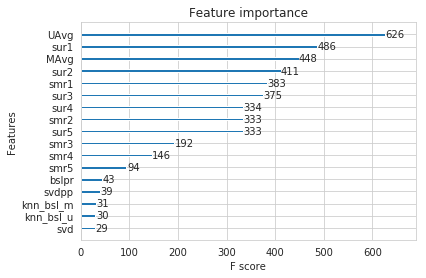

In [79]:
#xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
xgb_final = xgb.XGBRegressor(silent=False,n_jobs=10, random_state=15, 
                             max_depth=depth_gbdt
                           ,num_boost_round = num_boost_rount_gbdt
                           ,eta = eta_gbdt
                           ,subsample = subsample_gbdt
                           ,colsample_bytree = colsample_bytree_gbdt
                             ,n_estimators=best_n_estimators)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

### XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

In [80]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

In [81]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'n_estimators' : [3,5,7,9]
}

model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)  

# Summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

depth_gbdt = grid.best_params_['max_depth']
eta_gbdt = grid.best_params_['eta']
num_boost_rount_gbdt = grid.best_params_['num_boost_round']
subsample_gbdt = grid.best_params_['subsample']
colsample_bytree_gbdt = grid.best_params_['colsample_bytree']
best_n_estimators = grid.best_params_['n_estimators']

[01:08:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -1.223724 using {'n_estimators': 9, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.9, 'num_boost_round': 100, 'eta': 0.05}
Execution time: 401.8244571685791 ms


Training the model..
[01:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:02.715880

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.6538914730315537
MAPE :  40.24299821323136


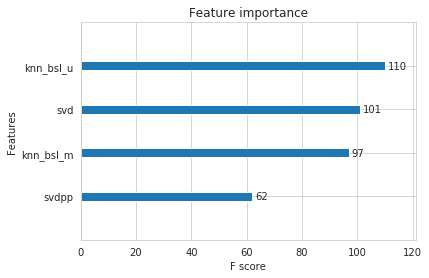

In [82]:
#xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
xgb_all_models = xgb.XGBRegressor(silent=False,n_jobs=10,
                                  random_state=15, 
                             max_depth=depth_gbdt
                           ,num_boost_round = num_boost_rount_gbdt
                           ,eta = eta_gbdt
                           ,subsample = subsample_gbdt
                           ,colsample_bytree = colsample_bytree_gbdt
                             ,n_estimators=best_n_estimators)

train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

## Conclusion

In [83]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0877628436804372
knn_bsl_u          1.087852478142926
knn_bsl_m         1.0881187106120334
bsl_algo          1.0882648990208073
svdpp             1.0902912614597926
xgb_bsl            1.625556549717856
first_algo         1.629753225231773
xgb_final         1.6407391206138895
xgb_knn_bsl       1.6407511491605584
xgb_all_models    1.6538914730315537
Name: rmse, dtype: object

 - Used more train data i.e. from 10,000 * 1000  to 25000 * 3000 
 - Used more test data i.e. from 5000 * 500 to 10000 * 1500
 - Hyperparameter tuning was performed on all models 